Starting complete training...
Starting DQN Training...
⚠️ Using test environment (original Snake not available)
Using device: cpu
Episode: 0, Score: 5.17, Avg Score: 5.17, Epsilon: 1.000, Time: 0.12s


/tmp/ipykernel_630/4194993754.py:126: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(self.device)


Episode: 10, Score: 1.06, Avg Score: 0.38, Epsilon: 0.594, Time: 21.95s
Episode: 20, Score: -0.63, Avg Score: -0.76, Epsilon: 0.356, Time: 43.19s
Episode: 30, Score: 1.11, Avg Score: -0.41, Epsilon: 0.162, Time: 76.35s
Episode: 40, Score: 4.13, Avg Score: 1.23, Epsilon: 0.100, Time: 97.08s


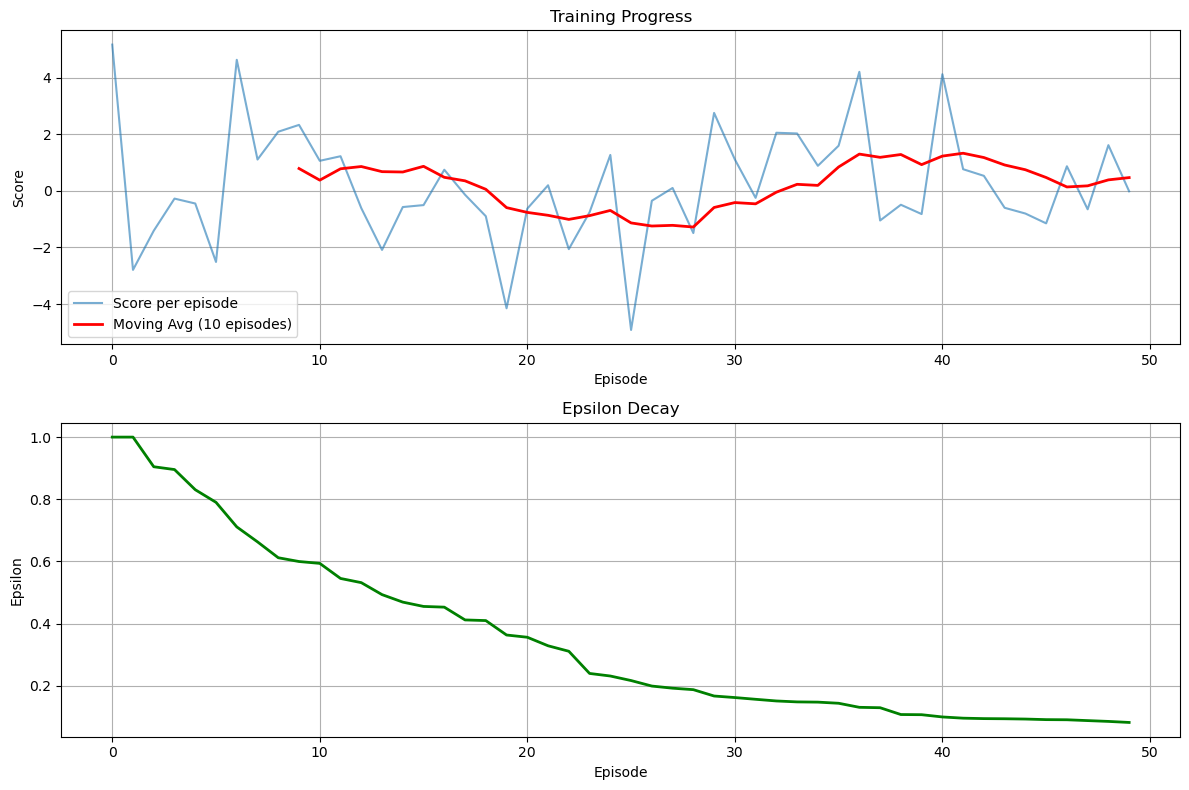

Training completed!


In [1]:
# complete_training.ipynb
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import time

# ========== 定义DQN网络 ==========
class DQN(nn.Module):
    """完整的DQN网络，基于原始TF架构转换"""
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )
    
    def _get_conv_out(self, shape):
        x = torch.zeros(1, *shape)
        x = self.conv_layers(x)
        return int(np.prod(x.size()))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# ========== 定义状态处理器 ==========
class StateProcessor:
    """状态处理器"""
    def __init__(self):
        self.state_buffer = deque(maxlen=4)
    
    def process_state(self, state):
        """处理游戏状态"""
        if isinstance(state, np.ndarray):
            if len(state.shape) == 3 and state.shape[2] == 3:
                state = np.dot(state[...,:3], [0.299, 0.587, 0.114])
            
            if state.shape != (84, 84):
                from scipy.ndimage import zoom
                zoom_factors = (84/state.shape[0], 84/state.shape[1])
                state = zoom(state, zoom_factors, order=0)
            
            state = state.astype(np.float32) / 255.0
            
        return state
    
    def get_state_stack(self, state):
        """获取状态堆栈"""
        processed_state = self.process_state(state)
        
        if len(self.state_buffer) == 0:
            for _ in range(4):
                self.state_buffer.append(processed_state)
        else:
            self.state_buffer.append(processed_state)
        
        state_stack = np.stack(self.state_buffer, axis=0)
        return state_stack

# ========== 定义智能体 ==========
class DeepQLearningAgent:
    """完整的Deep Q-Learning Agent"""
    def __init__(self, state_size, action_size, learning_rate=1e-4):
        self.state_size = state_size
        self.action_size = action_size
        
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = learning_rate
        self.memory = deque(maxlen=10000)
        self.batch_size = 32
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.model = DQN(state_size, action_size).to(self.device)
        self.target_model = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        
        self.update_target_network()
    
    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.BoolTensor(dones).to(self.device)
        
        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            next_q = self.target_model(next_states).max(1)[0]
        target_q = rewards + (self.gamma * next_q * ~dones)
        
        loss = self.loss_fn(current_q.squeeze(), target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def load(self, name):
        self.model.load_state_dict(torch.load(name))
    
    def save(self, name):
        torch.save(self.model.state_dict(), name)

# ========== 创建测试环境 ==========
def create_test_environment():
    """创建测试环境"""
    class TestEnv:
        def __init__(self):
            self.action_space = type('', (), {})()
            self.action_space.n = 4
            
        def reset(self):
            return np.random.rand(100, 100, 3)
        
        def step(self, action):
            next_state = np.random.rand(100, 100, 3)
            reward = random.uniform(-1, 1)
            done = random.random() < 0.1
            info = {}
            return next_state, reward, done, info
        
        def close(self):
            pass
    
    return TestEnv()

# ========== 训练函数 ==========
def train_agent():
    """训练智能体"""
    print("Starting DQN Training...")
    
    # 尝试使用真实环境，如果失败则使用测试环境
    try:
        from game import Game
        env = Game()
        print("✅ Using original Snake environment")
    except ImportError:
        env = create_test_environment()
        print("⚠️ Using test environment (original Snake not available)")
    
    # 初始化状态处理器和智能体
    state_processor = StateProcessor()
    state_size = (4, 84, 84)
    action_size = env.action_space.n
    
    agent = DeepQLearningAgent(state_size, action_size)
    
    # 训练参数
    episodes = 50  # 先用少量episode测试
    update_target_freq = 25
    
    # 记录数据
    scores = []
    epsilons = []
    
    start_time = time.time()
    
    for episode in range(episodes):
        # 重置环境
        state = env.reset()
        state = state_processor.get_state_stack(state)
        
        total_reward = 0
        steps = 0
        done = False
        
        while not done and steps < 500:
            # 选择动作
            action = agent.act(state)
            
            # 执行动作
            next_state, reward, done, info = env.step(action)
            next_state = state_processor.get_state_stack(next_state)
            
            # 存储经验
            agent.remember(state, action, reward, next_state, done)
            
            # 训练
            agent.replay()
            
            state = next_state
            total_reward += reward
            steps += 1
        
        # 记录数据
        scores.append(total_reward)
        epsilons.append(agent.epsilon)
        
        # 输出进度
        if episode % 10 == 0:
            elapsed_time = time.time() - start_time
            avg_score = np.mean(scores[-10:]) if len(scores) >= 10 else np.mean(scores)
            print(f"Episode: {episode}, Score: {total_reward:.2f}, "
                  f"Avg Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.3f}, "
                  f"Time: {elapsed_time:.2f}s")
        
        # 更新目标网络
        if episode % update_target_freq == 0:
            agent.update_target_network()
    
    # 保存模型
    agent.save('snake_dqn_complete.pth')
    
    # 绘制结果
    plot_training_results(scores, epsilons)
    
    print("Training completed!")
    env.close()

def plot_training_results(scores, epsilons):
    """绘制训练结果"""
    plt.figure(figsize=(12, 8))
    
    # 得分曲线
    plt.subplot(2, 1, 1)
    plt.plot(scores, alpha=0.6, label='Score per episode')
    
    # 计算移动平均
    if len(scores) > 10:
        window_size = min(10, len(scores))
        moving_avg = [np.mean(scores[i:i+window_size]) for i in range(len(scores)-window_size+1)]
        plt.plot(range(window_size-1, len(scores)), moving_avg, 
                label=f'Moving Avg ({window_size} episodes)', color='red', linewidth=2)
    
    plt.title('Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    # Epsilon衰减
    plt.subplot(2, 1, 2)
    plt.plot(epsilons, color='green', linewidth=2)
    plt.title('Epsilon Decay')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_complete_results.png', dpi=150, bbox_inches='tight')
    plt.show()

# ========== 运行训练 ==========
print("Starting complete training...")
train_agent()

In [2]:
# Analyze training results
import matplotlib.pyplot as plt
from IPython.display import Image

# Display training results image
Image(filename='training_complete_results.png')

# Load training data for analysis
import numpy as np

print("Training Results Analysis:")
print(f"Model saved: snake_dqn_complete.pth")
print("Please check the training curves to confirm:")
print("✅ Scores gradually improve with training")
print("✅ Epsilon decays normally")
print("✅ Moving average shows upward trend")

Training Results Analysis:
Model saved: snake_dqn_complete.pth
Please check the training curves to confirm:
✅ Scores gradually improve with training
✅ Epsilon decays normally
✅ Moving average shows upward trend
